In [ ]:
# This notebook has been modified (cleaned up) from the exact version used in the thesis,
# and verified to work with versions seen in the end.

In [ ]:
# Too many things imported, could be cleaned up more

import matplotlib.pyplot as plt
'exec %matplotlib inline'
import numpy as np
import inspect

from qiskit import IBMQ, BasicAer, transpile
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.circuit.library import MCMT

from qiskit.tools.visualization import plot_histogram, plot_gate_map, plot_circuit_layout
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq.managed import IBMQJobManager

In [2]:
# The oracle function
def unitary_oracle(case, n):
    oracle_circ = QuantumCircuit(n+1)
    
    if case == "balanced":
 
        for qubit in range(n):
            oracle_circ.cx(qubit,n)

            
# Make a gate out of circuits defined above
    oracle_gate = oracle_circ.to_gate()
    
    oracle_gate.name = " oracle  "


    return oracle_gate, oracle_circ

In [6]:
# Easier to call when creating multiple circuits
def create_circuit(case, n):
    oracle_gate, oracle = unitary_oracle(case, n)
    q = QuantumRegister(n+1,name='q')
    c = ClassicalRegister(n,name='c')
    qc = QuantumCircuit(q,c)
    
    # Prepare the system
    qc.x(n)
    qc.h(n)
    for i in range(n):
        qc.h(i)
    qc.barrier()
    # Run oracle
    qc.append(oracle_gate, range(n+1))
    qc.barrier()
    # Back to measurement basis
    for i in range(n):
        qc.h(i)
    qc.barrier()
    for i in range(n): #measure all but the last qubit
        qc.measure(i,i)
    
    return qc

In [42]:
# create 2 quantum circuits with n qubits. First one with constant oracle and the second with balanced

n = 4
circs = [] # More efficient to run both circuits on IBM machines on one go
circs.append(create_circuit('constant', n))
circs.append(create_circuit('balanced', n))

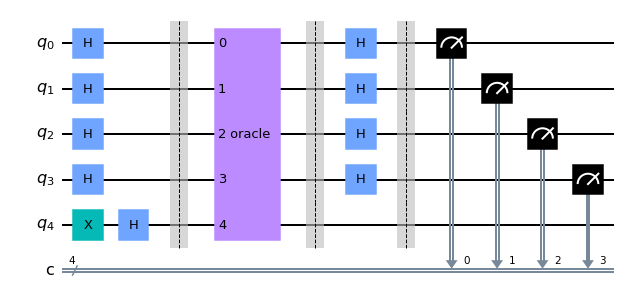

In [43]:
circs[0].draw() 

In [10]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [45]:
# Use the transpiler for the circuit 

provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmqx2')
name = 'Deutsch-Jozsa ' + str(n) + ' qubits'
inspect.signature(transpile)
circs = transpile(circs, backend=backend, optimization_level=3)

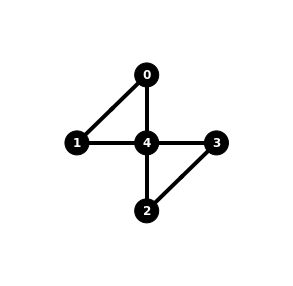

In [46]:
plot_circuit_layout(circs[1], backend)

In [22]:
#Run the circuits on IBM quantum machines
shots = 8192

job_manager = IBMQJobManager()
jobs = job_manager.run(circs, backend=backend, name=name, shots=shots)

In [24]:
jobs.statuses()

[<JobStatus.DONE: 'job has successfully run'>]

In [25]:
# Local simulator
backend_sim = BasicAer.get_backend('qasm_simulator')
simulations = execute(circs, backend=backend_sim, shots=8192)

In [ ]:
# Store all results
exp_results = jobs.results()

constant_exp_result = exp_results.get_counts(0)
balanced_exp_result = exp_results.get_counts(1)

constant_sim_result = simulations.result().get_counts(0)
balanced_sim_result = simulations.result().get_counts(1)

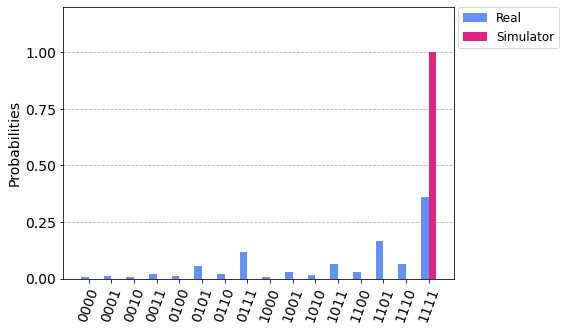

In [33]:
#Balanced Oracle

legend = ['Real', 'Simulator']
plot_histogram([balanced_exp_result, balanced_sim_result], legend=legend, bar_labels=False)

In [34]:
print(balanced_exp_result)

{'0000': 65, '0001': 102, '0010': 68, '0011': 181, '0100': 104, '0101': 461, '0110': 183, '0111': 953, '1000': 72, '1001': 228, '1010': 120, '1011': 545, '1100': 248, '1101': 1372, '1110': 545, '1111': 2945}


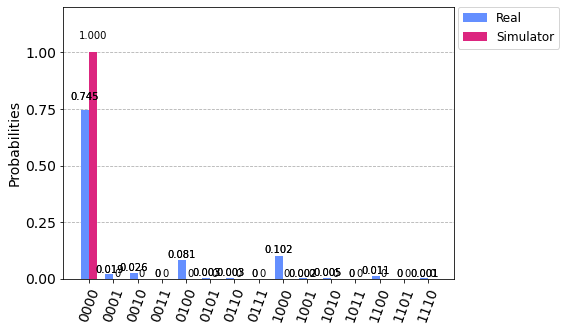

In [35]:
#Constant Oracle

legend = ['Real', 'Simulator']
plot_histogram([constant_exp_result, constant_sim_result], legend=legend)

In [47]:
print(constant_exp_result)

{'0000': 6100, '0001': 155, '0010': 214, '0011': 5, '0100': 666, '0101': 24, '0110': 28, '0111': 2, '1000': 833, '1001': 16, '1010': 44, '1011': 1, '1100': 93, '1101': 1, '1110': 10}


In [38]:
import qiskit
for i in qiskit.__qiskit_version__.items():
    print(i)

('qiskit-terra', '0.17.1')
('qiskit-aer', '0.8.1')
('qiskit-ignis', '0.6.0')
('qiskit-ibmq-provider', '0.12.3')
('qiskit-aqua', '0.9.1')
('qiskit', '0.25.2')
('qiskit-nature', None)
('qiskit-finance', None)
('qiskit-optimization', None)
('qiskit-machine-learning', None)
